# SMOTE Analysis

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imb_Pipeline
from sklearn.model_selection import GridSearchCV
import time

import sys
sys.path.insert(0, '../src')
import helpers as h

SEED = 123
holdoutseed = 4
CPU = -1
FOLDS = 5

In [43]:
def smote_params(clf, classifiers, X_train, y_train, X_test, y_test, RatioList, ScoringMethod, TimeIt=True):
    """
    Returns the classifiers dictionary updated with 4 enties related to 
        SMOTE optimum parameter analysis. 
        SMOTE_grid - DataFrame containing smote analysis results for plotting
        SMOTE_bestpart - 
        SMOTE_CVtrain_score - best search fit cross validate train score
        SMOTE_test_score - best search fit test score
    
    Parameters
    ----------
    clf - string, classifier to be analyzed
    classifiers - dictionary
    X_train, X_test - dataframes
    y_train, y_test - dataSeries
    RatioList - list, containing minority oversampling ratio values to test
    ScoringMethod - string, metric to be optimized
    TimeIt - boolean, flag for time processing time
    
    Returns
    -------
    Classifiers: dictionay
    """
    start_time = time.time()
    steps = [('scaler', StandardScaler()),
             ('SMOTE', SMOTE(random_state=SEED, n_jobs=CPU)),
             ('Classifier', classifiers[clf]['model'])]        
    pipeline = imb_Pipeline(steps)
    parameters = {'SMOTE__sampling_strategy': RatioList}
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    
    searcher = GridSearchCV(pipeline, param_grid=parameters, cv=kf, scoring=ScoringMethod)
    searcher.fit(X_train, y_train)
    
    df_gridCV = pd.DataFrame({'score': searcher.cv_results_['mean_test_score'],
                              'ResampleRatio': RatioList })
    
    classifiers[clf]['SMOTE_grid'] = df_gridCV
    classifiers[clf]['SMOTE_bestparm'] = searcher.best_params_['SMOTE__sampling_strategy']
    classifiers[clf]['SMOTE_CVtrain_score'] = searcher.best_score_
    classifiers[clf]['SMOTE_test_score'] = searcher.score(X_test, y_test)
    if TimeIt:
        t = time.time() - start_time
        print(f"{t:.0f} seconds execution time for {clf} classifier")
 
    return classifiers

In [76]:
def print_smote_parms(clf_lst, classifiers):
    for clf in clf_lst:
        print(classifiers[clf]['clf_desc'])
        print(f"Best CV params {classifiers[clf]['SMOTE_bestparm']}")
        print(f"Best CV value using training dataset: {classifiers[clf]['SMOTE_CVtrain_score']:.3f}")
        print(f"Best grid search fit using testing dataset: {classifiers[clf]['SMOTE_test_score']:.3f}\n")   

In [67]:
def plot_smote_parms(ax, clf, classifiers):
    df_gridCV = classifiers[clf]['SMOTE_grid'] 
    df_gridCV.plot(ax=ax, x='ResampleRatio', c=classifiers[clf]['c']);
    ax.set_title(f"{classifiers[clf]['clf_desc']}\nSMOTE Recall Scoring")
    ax.set_ylabel('Recall Score')

Positive Class frequency: 0.00173
LogisticRegression
169 seconds execution time for LR classifier
Best CV params 0.2
Best CV value using training dataset: 0.867
Best grid search fit using testing dataset: 0.873

RandomForest
1234 seconds execution time for RF classifier
Best CV params 0.04
Best CV value using training dataset: 0.835
Best grid search fit using testing dataset: 0.797

XGBoost
3615 seconds execution time for XGB classifier
Best CV params 0.15
Best CV value using training dataset: 0.832
Best grid search fit using testing dataset: 0.835



NameError: name 'plot_smote_parms' is not defined

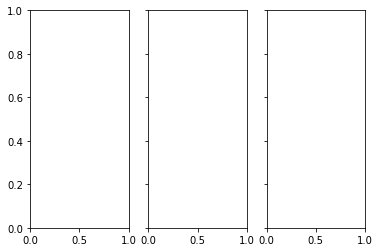

In [45]:

X_train, X_test, y_train, y_test, \
c_train, c_test, X_holdout, y_holdout, c_holdout, \
features = h.load_data(holdoutseed, engineered_features=False)

classifiers = h.load_classifier_dict("classifiers_ver03.pickle")
    
print('Positive Class frequency: {:.5f}'.format(y_train.mean()))
RatioList = [0.002, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.15, 0.20, 0.25]
ScoringMethod='recall'
clf_lst = ["LR", "RF", "XGB"]
for clf in clf_lst:
    smote_params(clf, classifiers, X_train, y_train, X_test, y_test, RatioList, ScoringMethod, TimeIt=True)

h.save_classifier_dict(classifiers, "04")

fig, axs = plt.subplots(1, len(clf_lst), sharey=True)
i = 0
for clf in clf_lst:
    plot_smote_parms(axs[i], clf, classifiers)

In [77]:
print_smote_parms(clf_lst, classifiers)

LogisticRegression
Best CV params 0.2
Best CV value using training dataset: 0.867
Best grid search fit using testing dataset: 0.873

RandomForest
Best CV params 0.04
Best CV value using training dataset: 0.835
Best grid search fit using testing dataset: 0.797

XGBoost
Best CV params 0.15
Best CV value using training dataset: 0.832
Best grid search fit using testing dataset: 0.835



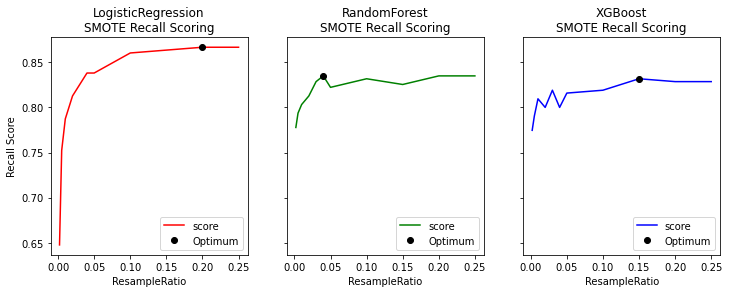

In [72]:
fig, axs = plt.subplots(1, len(clf_lst), figsize=(12,4), sharey=True)
i = 0
for clf in clf_lst:
    plot_smote_parms(axs[i], clf, classifiers)
    axs[i].plot(classifiers[clf]['SMOTE_bestparm'], classifiers[clf]['SMOTE_CVtrain_score'], 
                'ko', label="Optimum")
    axs[i].legend(loc='lower right')
    i += 1

In [73]:
fig.savefig("../images/smote_parms.png")

In [85]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.pipeline import Pipeline as imb_Pipeline

def update_pipeline(clf_lst, classifiers):
    for clf in clf_lst:
        steps = [('scaler', StandardScaler()),
                 ('SMOTE', SMOTE(random_state=SEED, n_jobs=CPU,
                                sampling_strategy=classifiers[clf]['SMOTE_bestparm'])),
                 ('Classifier', classifiers[clf]['model'])]        
        classifiers[clf]['pipeline'] = imb_Pipeline(steps) 
        
classifiers = h.load_classifier_dict("classifiers_ver04.pickle")        
clf_lst = ['LR','RF','XGB']
update_pipeline(clf_lst, classifiers)        
h.save_classifier_dict(classifiers, "04")

In [ ]:
# XGBoost with max_depth=5 (default is 6)
